In [1]:
from nltk.probability import ELEProbDist, FreqDist
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split

from collections import defaultdict
from nltk.tokenize import word_tokenize
import json
import nltk
import os, sys, json, argparse
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from string import punctuation

import urllib.request, html5lib
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import re
from nltk.tokenize.api import TokenizerI
from nltk.tokenize.util import align_tokens

# import punkt
from nltk.tokenize import TreebankWordTokenizer
import nltk.tokenize.punkt
from nltk.probability import FreqDist

In [2]:
SWdf = pd.read_csv('NLPout.csv')

In [3]:
d = {"RED LEADER": "RED_LEADER","BEN'S VOICE":"BEN","LUKE'S VOICE":'LUKE',"HAN'S VOICE":"HAN", "FIRST TROOPER":"TROOPER", "TROOPER VOICE":"TROOPER"}
SWdf = SWdf.replace(d)

In [30]:
chars = [ 'LEIA', 'BEN','TROOPER','VADER','WEDGE','THREEPIO','TARKIN','RED_LEADER','OFFICER','JABBA','BIGGS']
#'LUKE','HAN'
ccorpus = SWdf.loc[SWdf['char'].isin(chars)]
ccorpus = ccorpus[['text','char']]

trainx, testx = train_test_split(ccorpus, test_size=0.2)

ccorpus.drop(ccorpus.loc[ccorpus['char'] == "LUKE"]).sample(frac=.4).index

KeyError: "labels ['text' 'char'] not contained in axis"

In [5]:
ccorpus.loc[ccorpus['char'] == 'LUKE']

,text,char


In [6]:
trainy = trainx.apply(tuple, axis=1)
len(trainy)

360

In [7]:
# Make a new Tokenizer
stokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
wtokenizer = TreebankWordTokenizer()
#https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
xwords = []
xwords = stopwords.words('english')
xwords.extend([",","'s","(",")","...","'re","!","?","n't","'ll","'' ","'","--",";",".","''","``","get","'m","'ve","'d"])

In [9]:
train = []
for (words, cclass) in trainy:
    for e in words.split():
        if e not in xwords:
            e = re.sub(r'[^\w\s]','',e)
            #print(e)
            train.append((e, cclass))
len(train)


2402

In [10]:
def get_words_in_tweets(train):
    all_words = []
    for (words, cclass) in train:
      all_words.extend(words)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features



In [11]:
word_features = get_word_features(get_words_in_tweets(train))
len(word_features)

27

In [12]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features


In [13]:
training_set = nltk.classify.apply_features(extract_features, train)
len(training_set)

2402

In [14]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [15]:
def train(labeled_featuresets, estimator=ELEProbDist):
        """
        :param labeled_featuresets: A list of classified featuresets,
            i.e., a list of tuples ``(featureset, label)``.
        """
        label_freqdist = FreqDist()
        feature_freqdist = defaultdict(FreqDist)
        feature_values = defaultdict(set)
        fnames = set()

        # Count up how many times each feature value occurred, given
        # the label and featurename.
        for featureset, label in labeled_featuresets:
            label_freqdist[label] += 1
            for fname, fval in featureset.items():
                # Increment freq(fval|label, fname)
                feature_freqdist[label, fname][fval] += 1
                # Record that fname can take the value fval.
                feature_values[fname].add(fval)
                # Keep a list of all feature names.
                fnames.add(fname)

        # If a feature didn't have a value given for an instance, then
        # we assume that it gets the implicit value 'None.'  This loop
        # counts up the number of 'missing' feature values for each
        # (label,fname) pair, and increments the count of the fval
        # 'None' by that amount.
        for label in label_freqdist:
            num_samples = label_freqdist[label]
            for fname in fnames:
                count = feature_freqdist[label, fname].N()
                # Only add a None key when necessary, i.e. if there are
                # any samples with feature 'fname' missing.
                if num_samples - count > 0:
                    feature_freqdist[label, fname][None] += num_samples - count
                    feature_values[fname].add(None)

        # Create the P(label) distribution
        label_probdist = estimator(label_freqdist)

        # Create the P(fval|label, fname) distribution
        feature_probdist = {}
        for ((label, fname), freqdist) in feature_freqdist.items():
            probdist = estimator(freqdist, bins=len(feature_values[fname]))
            feature_probdist[label, fname] = probdist

        return label_probdist, feature_probdist

In [16]:
label_probdist, feature_probdist = train(training_set, estimator=ELEProbDist)

In [17]:
for c in chars:
    print(c, label_probdist.prob(c))

LEIA 0.10861889927310488
BEN 0.17798546209761162
TROOPER 0.03177570093457944
VADER 0.08951194184839045
WEDGE 0.021806853582554516
THREEPIO 0.29387331256490135
TARKIN 0.077466251298027
RED_LEADER 0.057528556593977154
OFFICER 0.02554517133956386
JABBA 0.03842159916926272
BIGGS 0.077466251298027


In [18]:
#for c in chars:
#    print(c, feature_probdist[(c, 'contains(have)')].prob(True))

In [19]:
print( classifier.show_most_informative_features(10))

Most Informative Features
             contains(z) = True            WEDGE : THREEP =     13.4 : 1.0
             contains(x) = True            JABBA : THREEP =     10.7 : 1.0
             contains(j) = True           OFFICE : THREEP =      8.2 : 1.0
             contains(k) = True            BIGGS : JABBA  =      3.9 : 1.0
             contains(f) = True              BEN : BIGGS  =      3.1 : 1.0
             contains(m) = True            VADER : OFFICE =      2.9 : 1.0
             contains(v) = True           RED_LE : VADER  =      2.8 : 1.0
             contains(w) = True            WEDGE : TROOPE =      2.7 : 1.0
             contains(l) = True             LEIA : WEDGE  =      2.7 : 1.0
             contains(y) = True            JABBA : TROOPE =      2.7 : 1.0
None


In [20]:
testy = testx.apply(tuple, axis=1)
len(testy)

testy

33     (of course i got it. signed aboard the rand ec...
262    (an elegant weapon for a more civilized time. ...
734                     (where could they be?, THREEPIO)
982                             (i have you now., VADER)
632                         (open up in there!, TROOPER)
87                        (things always change., BIGGS)
882    ((over speaker) can you see red five?, RED_LEA...
53     (how did i get into this mess? i really don't ...
71     (luke, i didn't come back just to say good-bye...
826    ((going off) you did, all right. it's going to...
261    (your fathers lightsaber. this is the weapon o...
998    (oh, my! artoo! can you hear me? say something...
779                           (their tracking us!, LEIA)
385    (i would much rather have gone with master luk...
208              (oh, he excels at that, sir., THREEPIO)
688               (we've had some problems..., THREEPIO)
17     (she'll be all right. inform lord vader we hav...
769    (there are still two mor

In [21]:
df = []
for (words, cclass) in testy:
    words = re.sub(r'[^\w\s]','',words)
    testout = classifier.classify(extract_features(words.split()))
    df.append({'line': words, 'char': cclass, 'pred':
        testout})
        

predictions = pd.DataFrame(df)
predictions

,char,line,pred
0,BIGGS,of course i got it signed aboard the rand ecli...,THREEPIO
1,BEN,an elegant weapon for a more civilized time fo...,THREEPIO
2,THREEPIO,where could they be,THREEPIO
3,VADER,i have you now,THREEPIO
4,TROOPER,open up in there,THREEPIO
5,BIGGS,things always change,THREEPIO
6,RED_LEADER,over speaker can you see red five,THREEPIO
7,THREEPIO,how did i get into this mess i really dont kno...,THREEPIO
8,BIGGS,luke i didnt come back just to say goodbye i s...,THREEPIO
9,BIGGS,going off you did all right its going to be li...,THREEPIO


In [22]:
predictions = predictions.sort_values('char')

In [23]:
char = list(predictions.char.unique())
char

#predictions.first()

['BEN',
 'BIGGS',
 'LEIA',
 'OFFICER',
 'RED_LEADER',
 'TARKIN',
 'THREEPIO',
 'TROOPER',
 'VADER',
 'WEDGE']

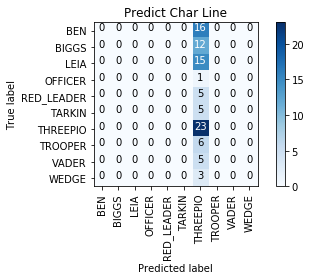

In [25]:
import itertools
from sklearn.metrics import  confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
def plot_confusion_matrix(cm, classes,
                          title='x',
                          cmap=plt.cm.Blues):
    
 #   print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnc_matrix = confusion_matrix(predictions["char"], predictions["pred"])
np.set_printoptions(precision=2)

# Compute confusion matrix
#cns_matrix = confusion_matrix(X_test["Position"], y_predp)
#np.set_printoptions(precision=2)

# Plot 
plt.figure()
plot_confusion_matrix(cnc_matrix, classes=char,
                      title='Predict Char Line')


plt.show()

# Plot 
#plt.figure()
#plot_confusion_matrix(cnc_matrix, classes=pcnames,
#                     title='Predict Char Line')


#plt.show()


